## Import Libraries

In [84]:
import os 
import pandas as pd 
import numpy as np
import seaborn as sns
import tensorflow as tf
import time 
import joblib 
import logging
import math 
import matplotlib.pyplot as plt 
import pickle
%matplotlib inline

from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, LSTM, GRU, RNN, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
from pylab import rcParams

In [85]:
sns.set(color_codes = True)
col_list = ['cerulean', 'scarlet']
sns.set(style = 'white', font_scale = 1.75, palette = sns.xkcd_palette(col_list))
rcParams['figure.figsize'] = 14, 8.7

In [86]:
tf.random.set_seed(123)
seed(123)

In [87]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [88]:
LABELS = ['Normal', 'FMA']

## GPU 

In [89]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)
else:
    print('No GPUs detected')

1 Physical GPUs 1 Logical GPUs


## Load Datas 

In [90]:
data = pd.read_csv('../../Datasets/Dataset_LaPalma_Labeled.csv', sep = ';')

In [91]:
data

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,19.0,17.11,15.0,6.0,270.00,5.1,1022.00,1021.1,1023.5,62.87,5905.56,18250.00,0
1,19.0,17.22,15.0,0.0,127.14,4.1,1020.38,1019.7,1021.4,65.52,16736.25,17466.67,0
2,21.0,18.00,14.0,0.0,222.86,5.1,1019.28,1018.4,1019.8,57.47,17840.00,15500.00,0
3,21.0,18.08,15.0,0.0,251.11,5.1,1021.35,1020.7,1022.6,64.18,22000.00,17250.00,0
4,20.0,18.31,15.0,0.0,228.00,4.1,1024.22,1022.6,1025.8,68.80,22000.00,16092.31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16748,24.0,19.51,16.5,0.0,230.69,4.1,1017.94,1016.9,1019.2,66.02,22000.00,12493.35,0
16749,25.0,20.48,18.0,0.0,232.50,6.2,1017.45,1016.0,1018.8,58.38,22000.00,13366.37,0
16750,29.0,21.95,17.5,0.0,236.94,8.8,1018.15,1016.7,1020.8,35.02,22000.00,14864.31,0
16751,24.0,20.15,17.0,0.0,213.19,4.1,1021.96,1020.5,1024.3,52.71,22000.00,14220.52,0


In [92]:
train = data[0:math.trunc(len(data) * 0.8)]
test = data[math.trunc(len(data) * 0.8):len(data)]

In [93]:
print("Dataset shape:", data.shape)
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train + Test entries:", train.shape[0] + test.shape[0])

Dataset shape: (16753, 13)
Train shape: (13402, 13)
Test shape: (3351, 13)
Train + Test entries: 16753


## FMA Filter 

In [94]:
train.describe()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
count,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000,13402.000000
mean,22.805238,20.935219,18.438793,1.737673,120.123328,7.071728,1019.253306,1018.260189,1020.184651,68.422541,13959.295977,15762.465313,0.029175
std,2.661810,2.524595,2.701410,11.144578,63.183407,2.919988,3.982056,4.166717,4.024172,8.472782,7297.619463,4673.234642,0.168302
min,15.000000,13.250000,-5.000000,0.000000,10.000000,0.000000,991.270000,978.500000,995.700000,16.400000,372.630000,1500.000000,0.000000
25%,21.000000,18.820000,16.200000,0.000000,73.550000,5.100000,1017.160000,1016.200000,1018.000000,63.280000,7873.330000,12766.670000,0.000000
50%,23.000000,20.830000,18.000000,0.000000,114.000000,6.700000,1019.385000,1018.500000,1020.200000,68.340000,15216.075000,14516.325000,0.000000
75%,25.000000,23.000000,20.800000,0.000000,162.000000,8.700000,1021.500000,1020.600000,1022.500000,73.940000,22000.000000,18036.360000,0.000000
max,38.000000,32.930000,31.000000,380.000000,360.000000,55.500000,1034.300000,1033.500000,1050.600000,96.570000,22000.000000,56000.000000,1.000000


In [95]:
train = train[train['FMA'] == 0]

In [96]:
train.shape

(13011, 13)

In [97]:
split = math.trunc(train.shape[0] * 0.2)
validation = train[-split:]
train = train[:-split]

In [98]:
print("Validation shape:", validation.shape)
print("Train shape:", train.shape)

Validation shape: (2602, 13)
Train shape: (10409, 13)


In [99]:
train_fma = train.iloc[:, -1]
validation_fma = validation.iloc[:, -1]
test_fma = test.iloc[:, -1]

In [100]:
train_fma.columns = ['train_fma']
validation_fma.columns = ['validation_fma']
test_fma.columns = ['test_fma']

In [101]:
test_fma.head()

13402    0
13403    0
13404    0
13405    0
13406    0
Name: FMA, dtype: int64

## Correlation 

In [102]:
train.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.964964,0.818017,-0.149909,-0.144776,0.032534,-0.258703,-0.223550,-0.282738,-0.000375,0.328227,-0.090179,NaN
temp_avg,0.964964,1.000000,0.904853,-0.147423,-0.210118,0.041334,-0.237653,-0.198193,-0.266852,0.045432,0.260569,-0.069445,NaN
temp_min,0.818017,0.904853,1.000000,-0.094237,-0.264497,0.101657,-0.161589,-0.115710,-0.199027,0.110459,0.067515,-0.062080,NaN
prec,-0.149909,-0.147423,-0.094237,1.000000,0.164071,0.078813,-0.121633,-0.133927,-0.103580,0.096535,-0.177002,-0.065321,NaN
wd,-0.144776,-0.210118,-0.264497,0.164071,1.000000,-0.237051,-0.162196,-0.179793,-0.128518,-0.127114,0.018030,0.043348,NaN
ws,0.032534,0.041334,0.101657,0.078813,-0.237051,1.000000,-0.027465,-0.034082,-0.030553,-0.164526,-0.060618,-0.129368,NaN
atmos_pres_avg,-0.258703,-0.237653,-0.161589,-0.121633,-0.162196,-0.027465,1.000000,0.979012,0.988318,-0.004777,-0.114897,0.020035,NaN
atmos_pres_min,-0.223550,-0.198193,-0.115710,-0.133927,-0.179793,-0.034082,0.979012,1.000000,0.948884,0.009853,-0.110620,0.026948,NaN
atmos_pres_max,-0.282738,-0.266852,-0.199027,-0.103580,-0.128518,-0.030553,0.988318,0.948884,1.000000,-0.011927,-0.116263,0.012538,NaN
rh,-0.000375,0.045432,0.110459,0.096535,-0.127114,-0.164526,-0.004777,0.009853,-0.011927,1.000000,-0.078423,0.019173,NaN


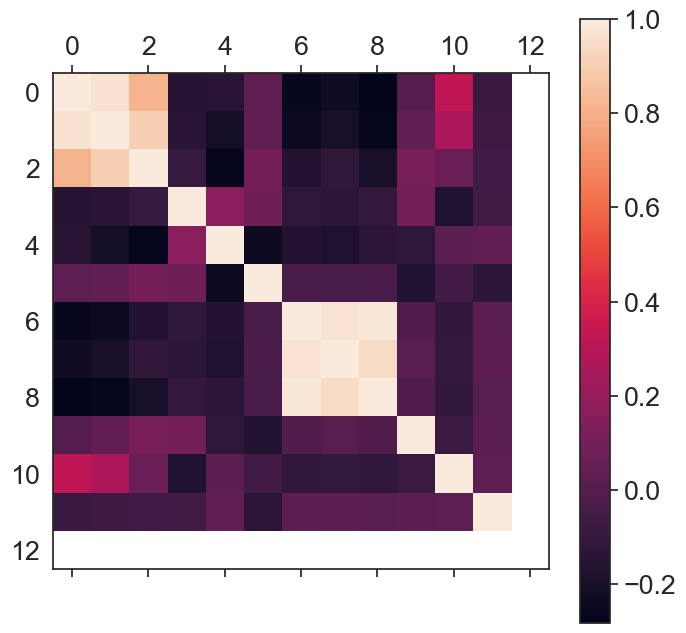

In [103]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

In [104]:
test.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.950503,0.861122,-0.059575,-0.112011,-0.084369,-0.370944,-0.343834,-0.389323,0.083622,0.188935,0.153253,-0.017183
temp_avg,0.950503,1.000000,0.937191,-0.046788,-0.191333,-0.090634,-0.367463,-0.333414,-0.398218,0.137254,0.161189,0.156857,-0.020007
temp_min,0.861122,0.937191,1.000000,-0.020058,-0.225100,0.011379,-0.300739,-0.271133,-0.327145,0.236400,0.028906,0.062896,-0.012419
prec,-0.059575,-0.046788,-0.020058,1.000000,0.175344,0.137660,-0.192556,-0.207892,-0.183051,0.132730,-0.042372,-0.103111,0.693851
wd,-0.112011,-0.191333,-0.225100,0.175344,1.000000,-0.272538,-0.072927,-0.096704,-0.037237,-0.127724,0.113577,-0.033153,0.174473
ws,-0.084369,-0.090634,0.011379,0.137660,-0.272538,1.000000,-0.047367,-0.074318,-0.023962,-0.026627,-0.175380,-0.126286,0.116853
atmos_pres_avg,-0.370944,-0.367463,-0.300739,-0.192556,-0.072927,-0.047367,1.000000,0.992282,0.990215,-0.126900,-0.112447,0.011384,-0.204917
atmos_pres_min,-0.343834,-0.333414,-0.271133,-0.207892,-0.096704,-0.074318,0.992282,1.000000,0.970223,-0.118150,-0.098882,0.018143,-0.223100
atmos_pres_max,-0.389323,-0.398218,-0.327145,-0.183051,-0.037237,-0.023962,0.990215,0.970223,1.000000,-0.126483,-0.123360,0.001046,-0.190136
rh,0.083622,0.137254,0.236400,0.132730,-0.127724,-0.026627,-0.126900,-0.118150,-0.126483,1.000000,-0.164091,-0.248246,0.050976


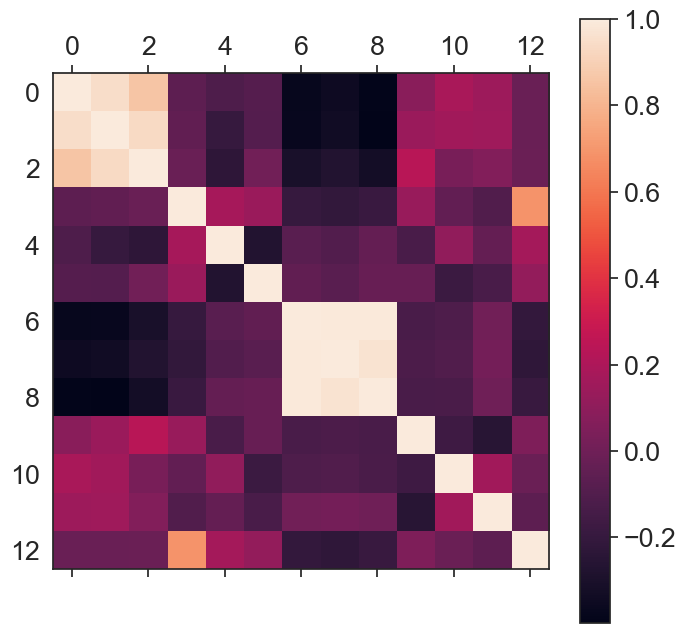

In [105]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(test.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Update Datas

In [106]:
train = train.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [107]:
test = test.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [108]:
validation = validation.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [109]:
print('Training shape:', train.shape)
print('Test shape:', test.shape)
print('Validation shape:', validation.shape)

Training shape: (10409, 6)
Test shape: (3351, 6)
Validation shape: (2602, 6)


In [110]:
train.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.147423,-0.210118,0.041334,-0.237653,0.045432
prec,-0.147423,1.000000,0.164071,0.078813,-0.121633,0.096535
wd,-0.210118,0.164071,1.000000,-0.237051,-0.162196,-0.127114
ws,0.041334,0.078813,-0.237051,1.000000,-0.027465,-0.164526
atmos_pres_avg,-0.237653,-0.121633,-0.162196,-0.027465,1.000000,-0.004777
rh,0.045432,0.096535,-0.127114,-0.164526,-0.004777,1.000000


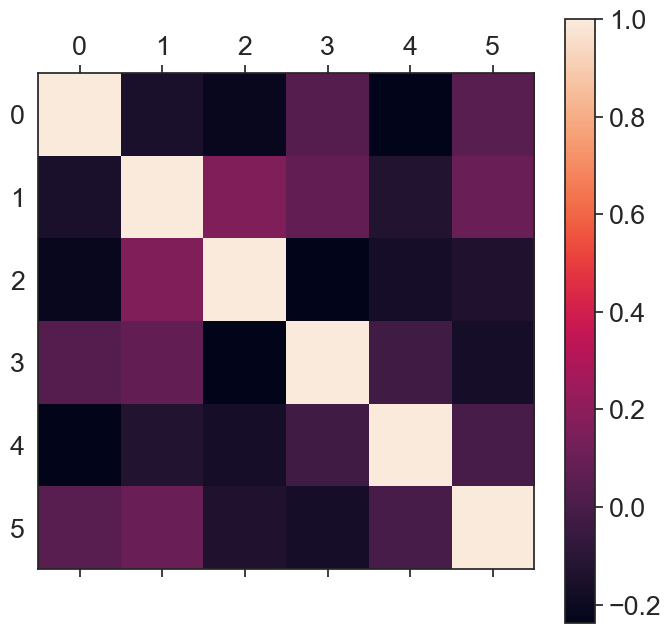

In [111]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

In [112]:
test.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.046788,-0.191333,-0.090634,-0.367463,0.137254
prec,-0.046788,1.000000,0.175344,0.137660,-0.192556,0.132730
wd,-0.191333,0.175344,1.000000,-0.272538,-0.072927,-0.127724
ws,-0.090634,0.137660,-0.272538,1.000000,-0.047367,-0.026627
atmos_pres_avg,-0.367463,-0.192556,-0.072927,-0.047367,1.000000,-0.126900
rh,0.137254,0.132730,-0.127724,-0.026627,-0.126900,1.000000


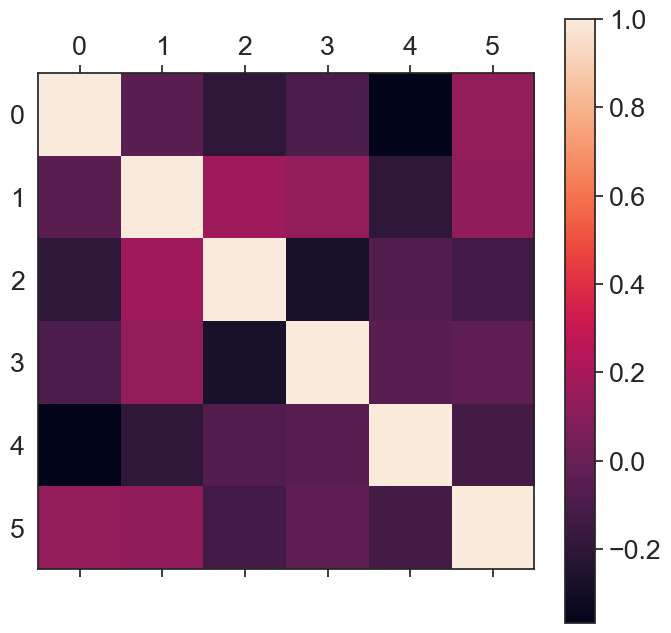

In [113]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(test.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Data Normalization 

In [114]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
x_validation = scaler.transform(validation)
scaler_filename = 'scaler_data_LaPalma'
joblib.dump(scaler, scaler_filename)

['scaler_data_LaPalma']

In [115]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_validation shape:', x_validation.shape)

x_train shape: (10409, 6)
x_test shape: (3351, 6)
x_validation shape: (2602, 6)


In [116]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1])

In [117]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_validation shape:', x_validation.shape)

x_train shape: (10409, 1, 6)
x_test shape: (3351, 1, 6)
x_validation shape: (2602, 1, 6)


## Model 

In [118]:
def autoencoder_model_GRU(X):
    inputs = Input(shape = (X.shape[1], X.shape[2]))
    
    L1 = GRU(32, activation = 'relu', return_sequences = True)(inputs)
    L2 = GRU(4, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(4, activation = 'relu', return_sequences = True)(L3)
    L5 = GRU(32, activation = 'relu', return_sequences = True)(L4)
    
    outputs = TimeDistributed(Dense(X.shape[2]))(L5)
    
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [119]:
model = autoencoder_model_GRU(x_train)
model.compile(optimizer = 'adamax', loss = 'mae', metrics = ['mae', 'mse', 'mape', 'msle', 'cosine_proximity'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 32)             3840      
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 456       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
gru_6 (GRU)                  (None, 1, 4)              120       
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 32)             3648      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 6)              198 

## Training 

In [120]:
dataframe_train = DataFrame()
dataframe_validation = DataFrame()

early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

for i in range(1):
    print('Fit model on training data...')
    start = time.time()
    
    epochs = 300
    batch_size = 32
    
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_validation, x_validation), callbacks=[early_stopping_callback], verbose = 0).history
    
    end = time.time()
    
    dataframe_train[str(i)] = history['loss']
    dataframe_validation[str(i)] = history['val_loss']
    
    print('Time to training model:', end - start)

Fit model on training data...
Epoch 00173: early stopping
Time to training model: 1874.8828337192535


## Training Results

In [121]:
loss = model.evaluate(x_train, x_train, verbose = 0)
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.04882879555225372
mae 0.04882879555225372
mse 0.009066694416105747
mape 456541.4375
msle 0.004517191555351019
cosine_proximity 0.9829133749008179


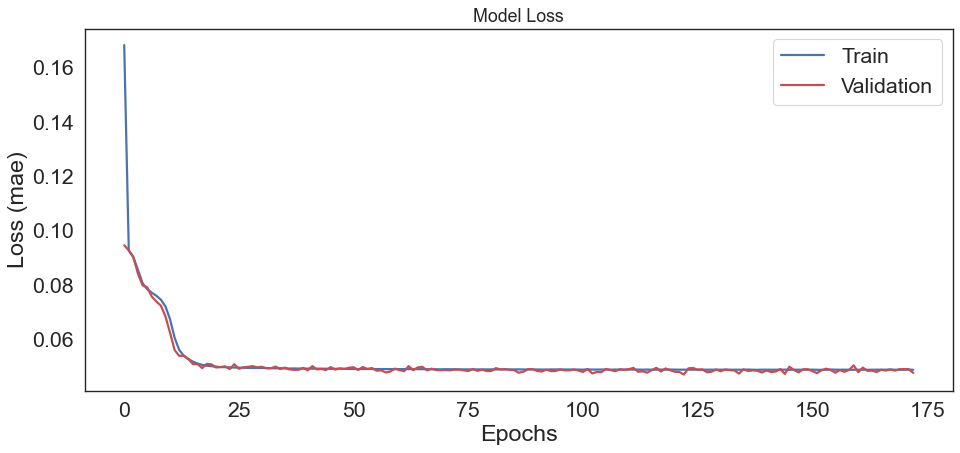

In [122]:
figure, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['loss'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_loss'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize = 16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epochs')
ax.legend(loc = 'upper right')
plt.show()

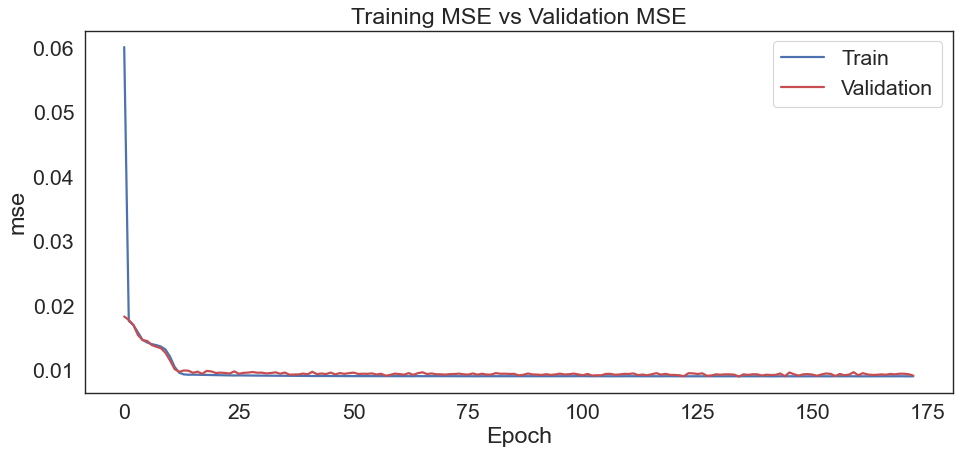

In [123]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_mse'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Training MSE vs Validation MSE')
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc = 'upper right')
plt.show()

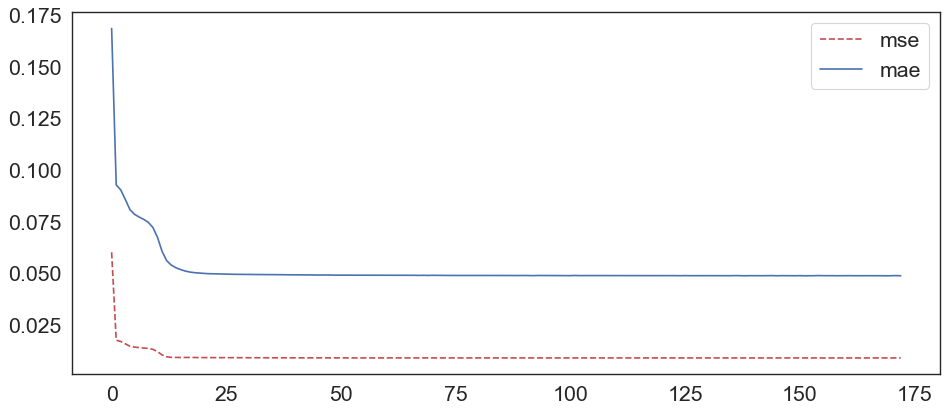

In [124]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'r--', label = 'mse')
ax.plot(history['mae'], 'b', label = 'mae')
ax.legend(loc = 'upper right')
plt.show()

### Distribution of Loss Function 

In [125]:
x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = train.columns)
x_pred.index = train.index

In [126]:
scored = pd.DataFrame(index = train.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred - Xtrain), axis = 1)

D:\TFG\Environment\TFG\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.4)

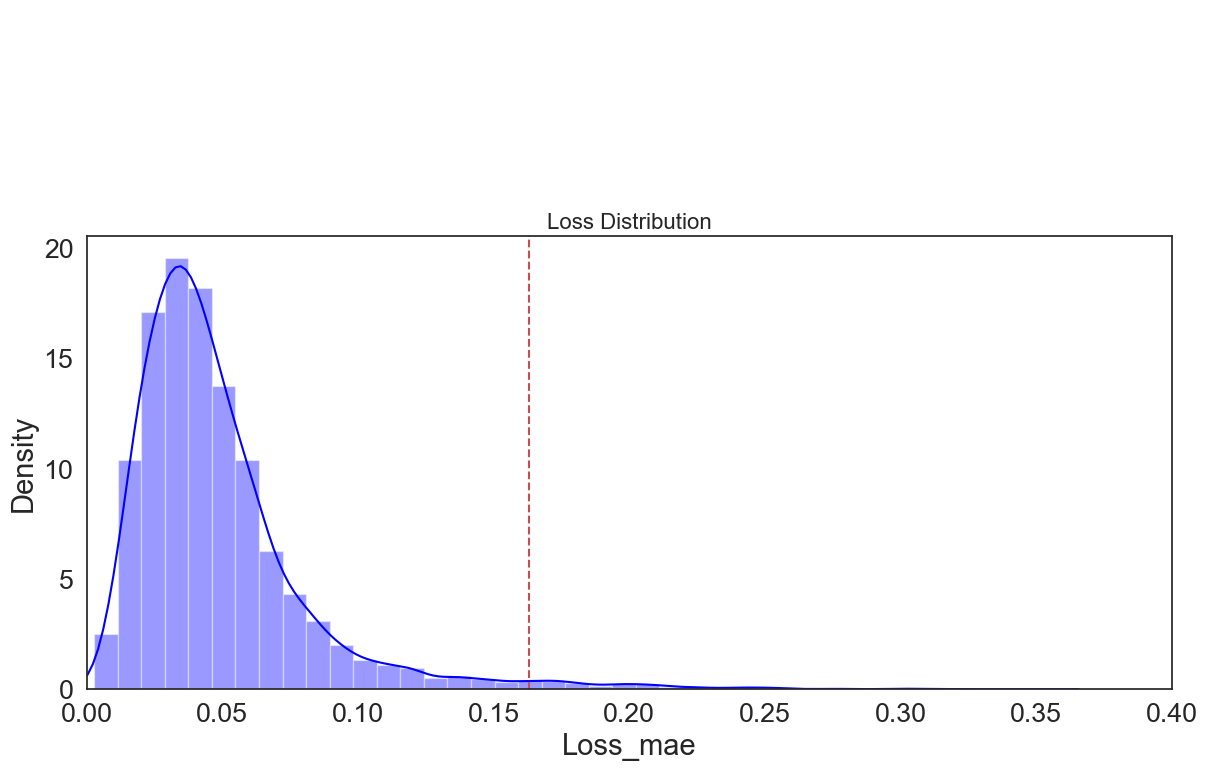

In [168]:
plt.figure(figsize = (14, 6), dpi = 100)
plt.title('Loss Distribution', fontsize = 16)
plt.axvline(0.163, ls = '--', color = 'r')
plt.annotate('Threshold = 0.163', xy = (0.06, 30), xycoords = 'data', fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
sns.distplot(scored['Loss_mae'], bins = 40, kde = True, color = 'blue')
plt.xlim([0.0, .4])

## Test Predictions 

In [128]:
x_pred = model.predict(x_test)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = test.columns)
x_pred.index = test.index

In [129]:
error_dataframe = pd.DataFrame(index = test.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
error_dataframe['Reconstruction_error'] = np.mean(np.power(x_pred - Xtest, 2), axis = 1)
error_dataframe['True_class'] = test_fma
error_dataframe.head()

,Reconstruction_error,True_class
13402,0.002922,0
13403,0.002374,0
13404,0.002230,0
13405,0.006039,0
13406,0.004507,0


In [148]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)

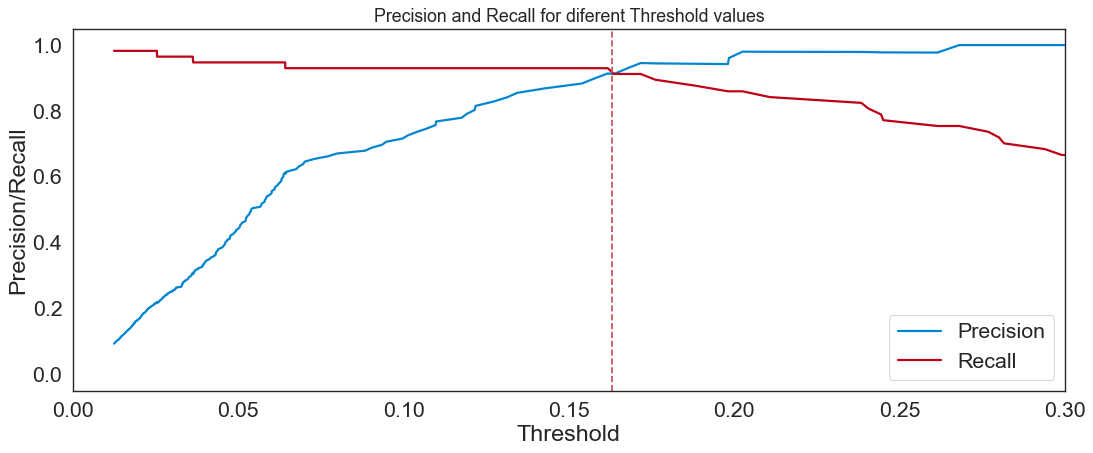

In [153]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(threshold, precision[1:], label = 'Precision', linewidth = 2)
ax.plot(threshold, recall[1:], label = 'Recall', linewidth = 2)
ax.set_title('Precision and Recall for diferent Threshold values', fontsize = 16)
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')
ax.set_xlim([0.0, 0.3])
ax.axvline(0.163, ls = '--', color = 'r')
ax.legend(loc = 'lower right')
plt.show()

### ROC Curve Check

In [132]:
false_pos_rate, true_pos_rate, threshold = roc_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

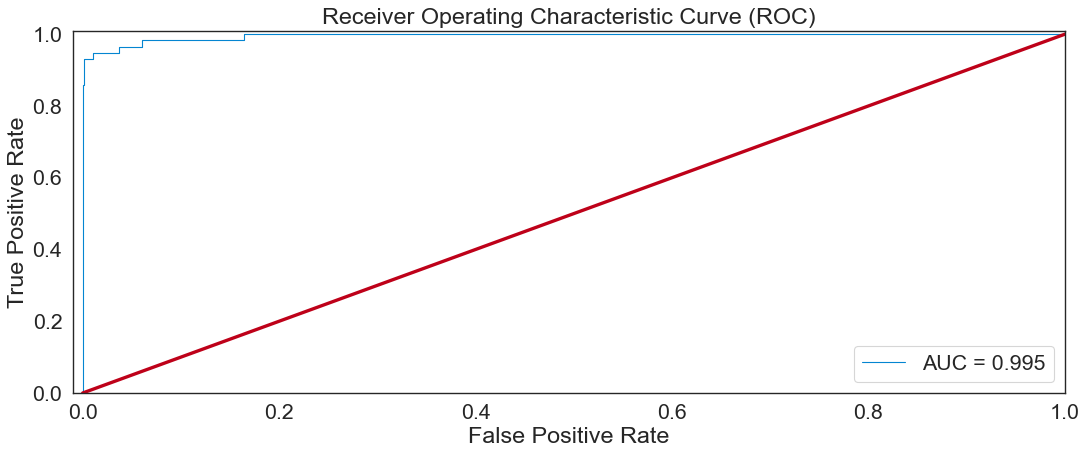

In [133]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(false_pos_rate, true_pos_rate, linewidth = 1, label = 'AUC = %0.3f' % roc_auc)
ax.plot([0,1], [0,1], linewidth = 3)
ax.set_title('Receiver Operating Characteristic Curve (ROC)')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc = 'lower right')
plt.show()

### Recall VS Precision Thresholding 

In [134]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)

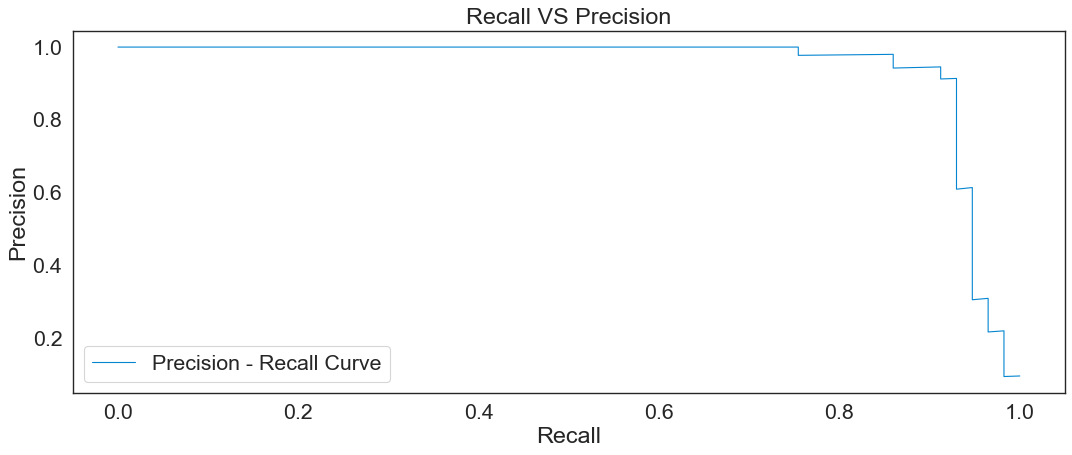

In [135]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(recall, precision, linewidth = 1, label = 'Precision - Recall Curve')
ax.set_title('Recall VS Precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc = 'lower left')
plt.show()

### Reconstruction Error VS Threshold Check

In [154]:
threshold_fixed = 0.163
groups = error_dataframe.groupby('True_class')

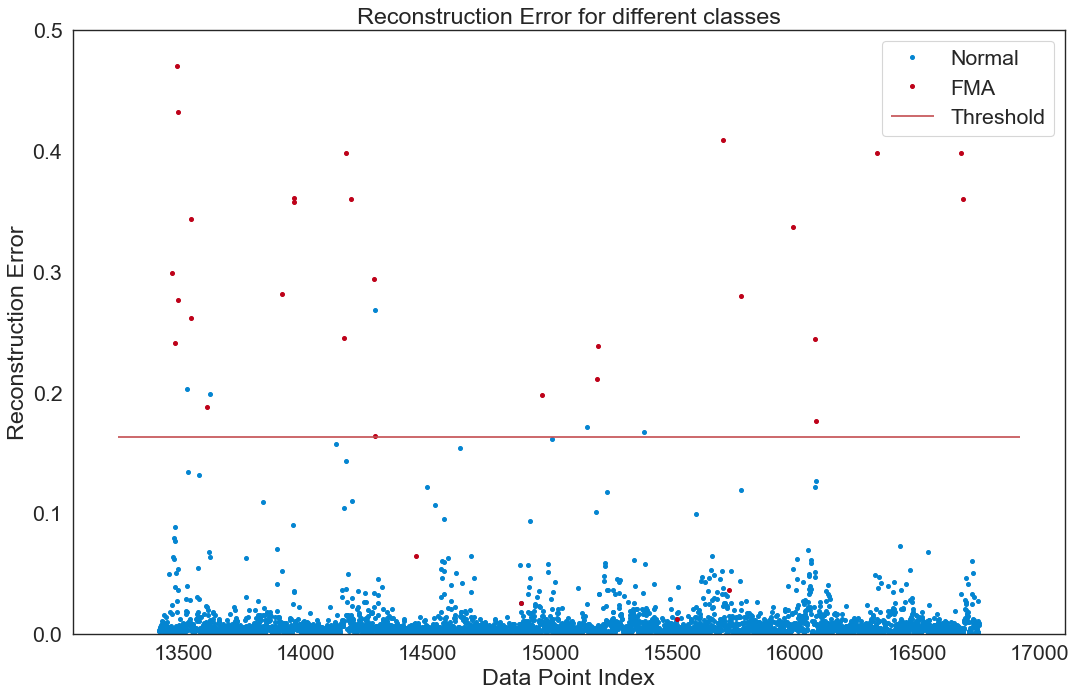

In [155]:
fig, ax = plt.subplots(figsize = (16, 10), dpi = 80)

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '', label = 'FMA' if name == 1 else 'Normal')
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder = 100, label = 'Threshold')
ax.set_title('Reconstruction Error for different classes')
ax.set_ylabel('Reconstruction Error')
ax.set_xlabel('Data Point Index')
ax.set_ylim([0, 0.5])
ax.legend(loc = 'upper right')
plt.show()

### Confusion Matrix 

In [156]:
pred_y = [1 if error > threshold_fixed else 0 for error in error_dataframe.Reconstruction_error.values]

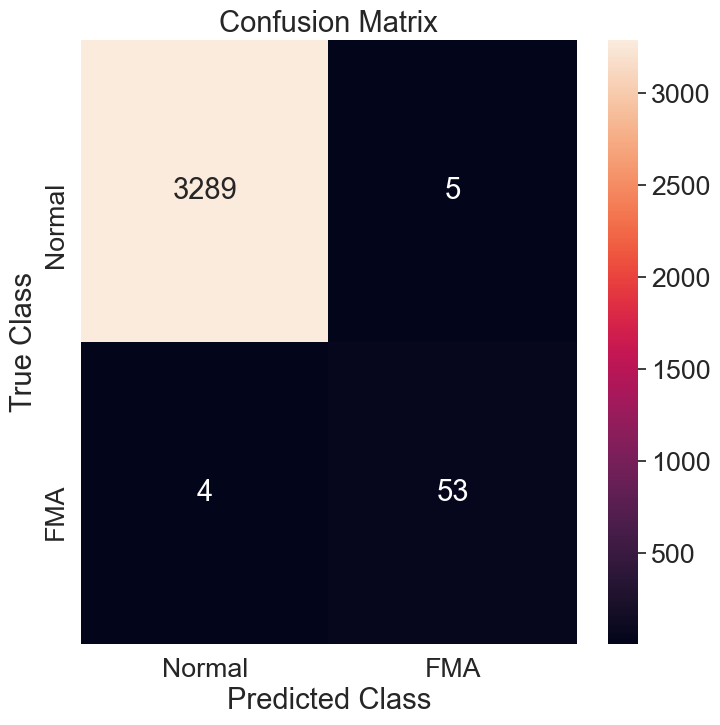

In [157]:
matrix = confusion_matrix(error_dataframe.True_class, pred_y)
fig, ax = plt.subplots(figsize = (8, 8), dpi = 100)
sns.heatmap(matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
plt.show()

### Reconstruction Error - Test Set 

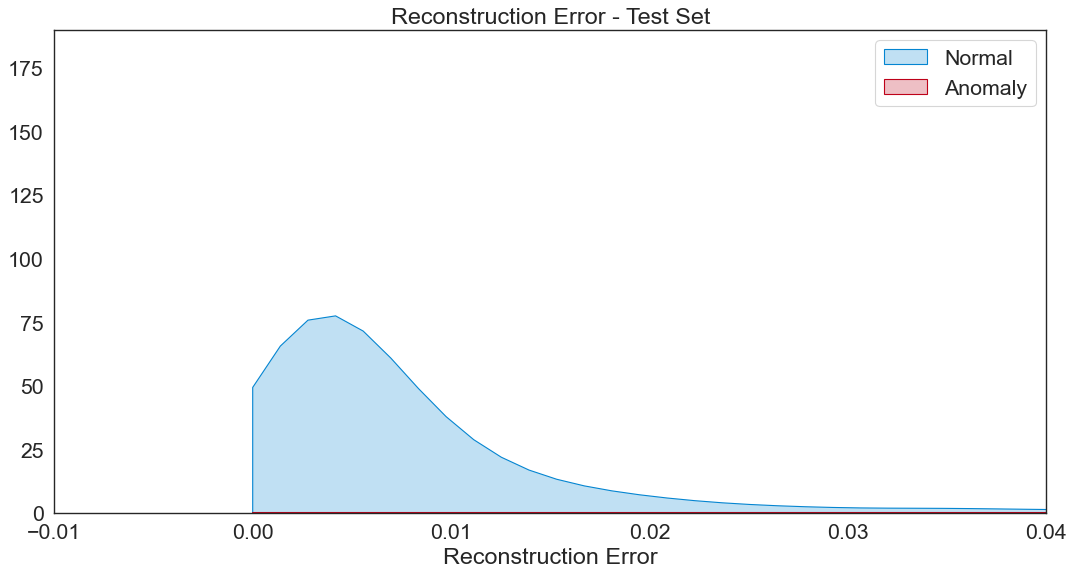

In [158]:
fig, ax = plt.subplots(figsize = (16, 8), dpi = 80)
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 0], label = 'Normal', shade = True, clip = (0, 10))
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 1], label = 'Anomaly', shade = True, clip = (0, 10))
ax.set_title('Reconstruction Error - Test Set')
ax.set_xlim([-0.01, 0.04])
ax.set_ylim([0, 190])
ax.set_xlabel('Reconstruction Error')
ax.set_ylabel('')
ax.legend(loc = 'upper right')
plt.show()

## Thresholds 

### Threshold with Max  

In [159]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_max = np.max(train_loss)
print("Reconstruction error threshold with max: ", threshold_max)

Reconstruction error threshold with max:  1.000100489705801


### Threshold with Mean and Std

In [160]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_mean_std = np.mean(train_loss) + np.std(train_loss)
print("Reconstruction error threshold with mean and std: ", threshold_mean_std)

Reconstruction error threshold with mean and std:  0.13057501280547165


### Threshold Precision ∩ Recall

In [ ]:
def intersection_point():
    precision_points = np.array([[threshold[i],precision[i+1]] for i in range(len(precision[1:]))])
    recall_points = np.array([[threshold[i],recall[i+1]] for i in range(len(recall[1:]))])
    nrows, ncols = precision_points.shape
    dtype = {'names': ['f{}'.format(i) for i in range(ncols)], 'formats': ncols * [precision_points.dtype]}
    intersection = np.intersect1d(precision_points.view(dtype), recall_points.view(dtype))
    return intersection.view(precision_points.dtype).reshape(-1, ncols)

In [ ]:
threshold_precision_recall = intersection_point()[0][0]

In [ ]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}\n".format(ll))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred, target_names = LABELS))
    print("Fbeta Score(0.5):{:.3f}".format(fbeta_score(ytest, ypred, average="micro", beta=0.5)))

In [ ]:
threshold_fixed = [threshold_max, threshold_mean_std, threshold_precision_recall]

print('------------------------------------------------------------------------------')

for threshold in threshold_fixed: 
    pred_y = [1 if error > threshold else 0 for error in error_dataframe.Reconstruction_error.values]
    matrix = confusion_matrix(error_dataframe.True_class, pred_y)
    
    precision = precision_score(error_dataframe.True_class, pred_y, average = 'weighted')
    recall = recall_score(error_dataframe.True_class, pred_y, average = 'weighted')
    fbeta = fbeta_score(error_dataframe.True_class, pred_y, beta = 0.5)
    
    print('Result:\n')
    print('Precision Score = %.3f\nRecall Score = %.3f\nFbeta Score = %.3f\n' % (precision, recall, fbeta))
    print('Threshold fixed = %.3f' % threshold)
    print_stats(error_dataframe.True_class, pred_y)
    print('------------------------------------------------------------------------------')

### Historic

In [166]:
#model.save("../../Historical/LaPalma/GRU_PALMA.h5")

In [167]:
#with open('../../Historical/LaPalma/GRU_PALMA.txt', 'wb') as file_pi:
#    pickle.dump(history, file_pi)